In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns

from sqlite3 import Error


%matplotlib inline

In [2]:
coins = ['Bitcoin', 'Ethereum', 'Dogecoin']#you get csv into pandas then we 

btc = pd.read_csv('Bitcoin.csv')
eth = pd.read_csv('Ethereum.csv')
doge = pd.read_csv('Dogecoin.csv')

In [3]:
btc['ticker'] = np.array(['btc']*len(btc))#add identifier column because you dump everyting into one datatbase
eth['ticker'] = np.array(['eth']*len(eth))
doge['ticker'] = np.array(['doge']*len(doge))

In [ ]:
btc.to_csv('btc.csv', index=False)
eth.to_csv('eth.csv', index=False)
doge.to_csv('doge.csv', index=False)

In [ ]:
def create_connection(db_file, delete_db=False):# iterative function it create connection
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):# this will create table in datatbase
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):# it execute sql statment 
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows


In [ ]:
non_normalized_db = 'non_normalized.db'# create non normalise connection
non_norm_conn = create_connection(non_normalized_db, delete_db=True)

In [ ]:
non_normalized_sql = ''' CREATE TABLE IF NOT EXISTS cryptocurrencies (      
                            date TEXT NOT NULL,
                            open REAL NOT NULL,
                            high REAL NOT NULL,
                            low REAL NOT NULL,
                            close REAL NOT NULL,
                            volume REAL NOT NULL,
                            market_cap REAL NOT NULL,
                            ticker TEXT NOT NULL
                            );'''

create_table(non_norm_conn, non_normalized_sql, drop_table_name=True)# create table inside non normalise connection

In [ ]:
def insert_non_norm(conn, tickers):# insert csv data into non normalised dtabase
    dates = []
    opens = []
    highs = []
    lows = []
    closes = []
    vol = []
    mcap = []
    tiks = []
    for ticker in tickers:
        with open(ticker + '.csv', 'r') as f:
            data = f.read()
            for row in data.split('\n')[1:-1]:
                dates.append(row.split(',')[0])
                opens.append(float(row.split(',')[1]))
                highs.append(float(row.split(',')[2]))
                lows.append(float(row.split(',')[3]))
                closes.append(float(row.split(',')[4]))
                vol.append(float(row.split(',')[5]))
                mcap.append(float(row.split(',')[6]))
                tiks.append(row.split(',')[7])
    data = tuple(zip(dates, opens, highs, lows, closes, vol, mcap, tiks))
    insert_sql = ''' INSERT INTO cryptocurrencies VALUES(?, ?, ?, ?, ?, ?, ?, ?)'''
    cursor = conn.cursor()
    cursor.executemany(insert_sql, data)
    conn.commit()
    

In [ ]:
insert_non_norm(non_norm_conn, ['btc', 'eth', 'doge'])

In [ ]:
def setup_norm_db(normalized_db):# setup normalised database and create tables inside it
    
    tickers_table_sql = ''' CREATE TABLE IF NOT EXISTS tickers (
                            ticker_id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
                            name TEXT NOT NULL
                            );'''
    dates_table_sql = '''CREATE TABLE IF NOT EXISTS timeseries_data (
                         date TEXT NOT NULL,
                         open REAL NOT NULL,
                         high REAL NOT NULL,
                         low REAL NOT NULL,
                         close REAL NOT NULL,
                         volume REAL NOT NULL,
                         mkcap REAL NOT NULL,
                         ticker_id INTEGER NOT NULL,
                         FOREIGN KEY (ticker_id) REFERENCES tickers (ticker_id)
                         )'''
    with create_connection(normalized_db, delete_db=True) as conn:
        create_table(conn, tickers_table_sql, drop_table_name='tickers')
        create_table(conn, dates_table_sql, drop_table_name='timeseries_data')


def normalize_db(normalized_db, non_normalized_db):# fetch data from non normalised database, process it insert into normalised database table
    with create_connection(non_normalized_db) as non_norm_conn:
        retrieve_data_sql = """SELECT * FROM cryptocurrencies;"""
        raw_data = execute_sql_statement(retrieve_data_sql, non_norm_conn)

        
    _tiks = set()
    for i in raw_data:
        _tiks.add(i[-1])
    _tiks = tuple(sorted(list([(x,) for x in _tiks])))

    with create_connection(normalized_db) as norm_conn:
        insert_tiks_sql = '''INSERT INTO tickers (name) VALUES (?);'''
        cursor = norm_conn.cursor()
        cursor.executemany(insert_tiks_sql, _tiks)
        
        
        _tiks_dict = {}
        for i in execute_sql_statement('SELECT * FROM tickers;', norm_conn):
            _tiks_dict[i[1]] = i[0]    
            
        timeseries_sql = '''INSERT INTO timeseries_data VALUES (?, ?, ?, ?, ?, ?, ?, ?)'''
        data_to_insert = []
        for row in raw_data:
            edit_row = list(row)
            edit_row[-1] = _tiks_dict[edit_row[-1]]
            edit_row = tuple(edit_row)
            cursor.execute(timeseries_sql, edit_row)
        norm_conn.commit()

In [ ]:
setup_norm_db('normalized.db')

In [ ]:
normalize_db('normalized.db', 'non_normalized.db')#normalised db

# Database Schema

<img src="Schema.png">

# Prepare pandas 

In [ ]:
to_pandas_sql = """SELECT * from timeseries_data td join tickers t on td.ticker_id = t.ticker_id"""#fetch data from non normalise database into single data frame
conn = create_connection('normalized.db')
df = pd.read_sql_query(to_pandas_sql, conn)
conn.close()

In [ ]:
df.head()# sorted

In [ ]:
df = df.drop(['ticker_id'], axis=1)# drop extra ticker id colum because there were 2 same colums
df.loc[:, 'date'] = pd.to_datetime(df['date'], dayfirst=True)

In [ ]:
df.dtypes

date      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
volume           float64
mkcap            float64
name              object
dtype: object

In [ ]:
df = df.sort_values(['name', 'date'])

In [ ]:
btc = df[df['name']=='btc']# create seprate df for each coin
doge = df[df['name']=='doge']
eth = df[df['name']=='eth']

Text(0.5, 0.98, 'Coin performance')

<Figure size 1440x720 with 0 Axes>

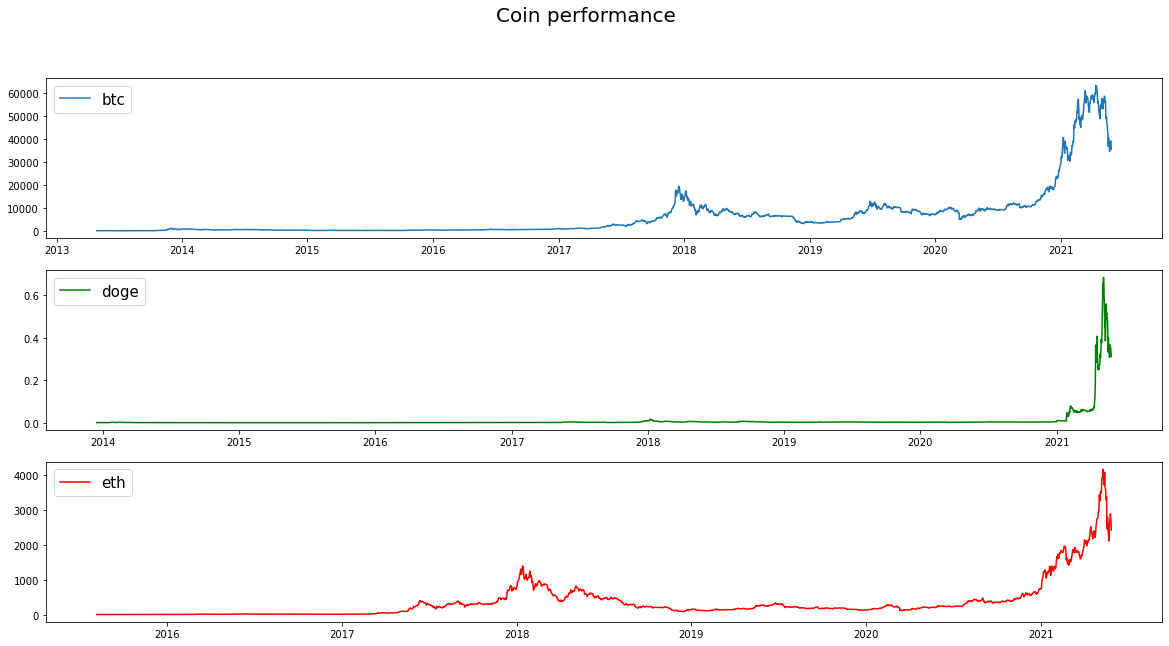

In [ ]:
plt.figure(figsize=(20,10))# plot time vs price for each coin
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,10))
ax[0].plot(btc['date'], btc['close'], label='btc')
ax[0].legend(fontsize=15)
ax[1].plot(doge['date'], doge['close'], label='doge', color='green')
ax[1].legend(fontsize=15)
ax[2].plot(eth['date'], eth['close'], label='eth', color='red')
ax[2].legend(fontsize=15)
fig.suptitle('Coin performance', fontsize=20)

Adjust dates for the selected coins to include identical time periods

In [ ]:
# min ETH date
eth['date'].min()

Timestamp('2015-08-07 00:00:00')

In [ ]:
btc = btc[btc['date'] >= '2015-08-07' ]# adjust dates for coins the time lines match
doge = doge[doge['date'] >= '2015-08-07']

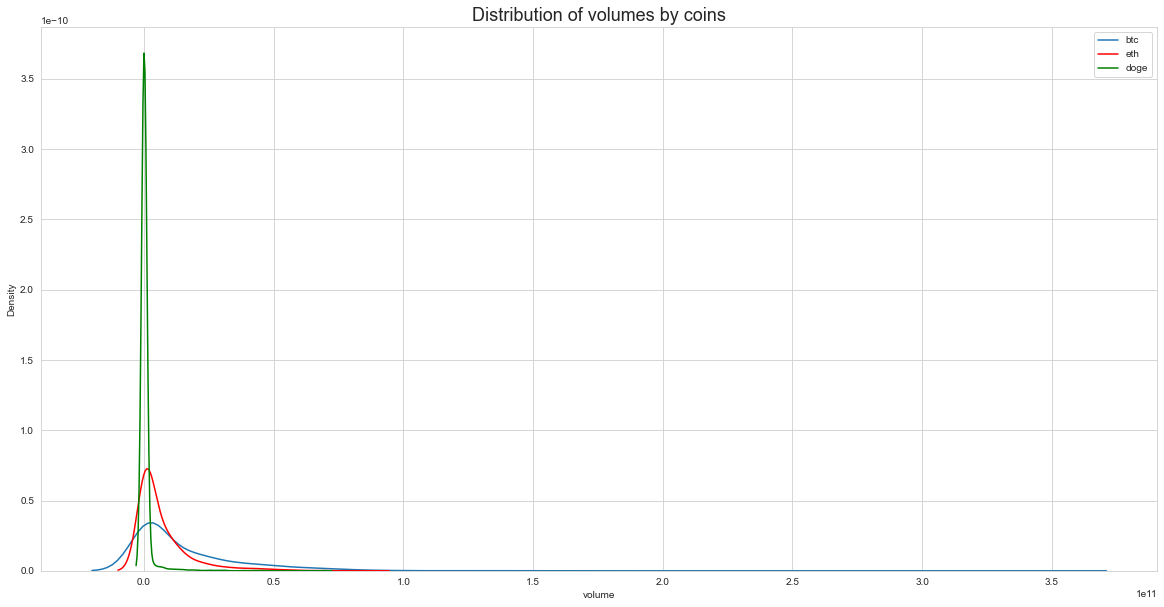

In [ ]:
plt.figure(figsize=(20,10))# distribution of volumes of each coin
sns.set_style('whitegrid')
sns.kdeplot(btc.volume, bw_adjust=1.5, label='btc')
sns.kdeplot(eth.volume, bw_adjust=1.5, label='eth', color='red')
sns.kdeplot(doge.volume, bw_adjust=1.5, label='doge', color='green')
plt.title('Distribution of volumes by coins', fontsize=18)
plt.legend()

In [ ]:
import sys

In [ ]:
!pip install --prefix {sys.prefix} pandas_ta

In [ ]:
import pandas_ta

In [ ]:
btc.ta.ema(close='close', length=7, append=True)# creates 7 days moving average close price for each coin
doge.ta.ema(close='close', length=7, append=True)
eth.ta.ema(close='close', length=7, append=True)

In [ ]:
btc.dropna(axis=0, inplace=True)# delete row with missing values
doge.dropna(axis=0, inplace=True)
eth.dropna(axis=0, inplace=True)

<ipython-input-187-1c427f90b973>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth.dropna(axis=0, inplace=True)


In [ ]:
btc

,date,open,high,low,close,volume,mkcap,name,EMA_7
2115,2015-08-13,266.183014,266.231995,262.841003,264.079987,2.768550e+07,3.827589e+09,btc,267.282427
2114,2015-08-14,264.131989,267.466003,261.477997,265.679993,2.709120e+07,3.851716e+09,btc,266.881818
2113,2015-08-15,265.528992,266.666992,261.295990,261.550995,1.932110e+07,3.792758e+09,btc,265.549113
2112,2015-08-16,261.865997,262.440002,257.040985,258.506989,2.971700e+07,3.749502e+09,btc,263.788582
2111,2015-08-17,258.489990,260.505005,257.117004,257.976013,2.161790e+07,3.742748e+09,btc,262.335439
...,...,...,...,...,...,...,...,...,...
4,2021-05-24,34700.363568,39835.139830,34551.080550,38705.978637,6.735958e+10,7.243321e+11,btc,39200.478698
3,2021-05-25,38795.780250,39776.349798,36581.428916,38402.223851,5.621192e+10,7.188294e+11,btc,39000.914986
2,2021-05-26,38392.623656,40782.078183,37905.834854,39294.197382,5.134674e+10,7.355564e+11,btc,39074.235585
1,2021-05-27,39316.889678,40379.617672,37247.903676,38436.968535,4.321097e+10,7.195381e+11,btc,38914.918823


In [ ]:
from sklearn.linear_model import LinearRegression# you need to predict the value

In [ ]:
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(btc[['open', 'EMA_7']], btc['close'], shuffle=False, test_size = 0.1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(doge[['open', 'EMA_7']], doge['close'], shuffle=False, test_size = 0.1)
X_train3, X_test3, y_train3, y_test3 = train_test_split(eth[['open', 'EMA_7']], eth['close'], shuffle=False, test_size = 0.1)

In [ ]:
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train1, y_train1, shuffle=False, test_size = 0.1)# create train 80%, validation 10% and test 10%
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, shuffle=False, test_size = 0.1)
X_train3, X_val3, y_train3, y_val3 = train_test_split(X_train3, y_train3, shuffle=False, test_size = 0.1)

In [ ]:
model1 = LinearRegression()# create model for each data frame and train seprately
model2 = LinearRegression()
model3 = LinearRegression()

model1.fit(X_train1, y_train1)
model2.fit(X_train2, y_train2)
model3.fit(X_train3, y_train3)

LinearRegression()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score# common metrics to assess model quality

In [ ]:
y_pred1 = model1.predict(X_val1)# predict on validation set
y_pred2 = model2.predict(X_val2)
y_pred3 = model3.predict(X_val3)

In [ ]:
print("BTC r2 score", r2_score(y_val1, y_pred1))# how much variation could be explain by features etherum has the best r2 score
print("DOGE r2 score", r2_score(y_val2, y_pred2))
print('ETH r2 score', r2_score(y_val3, y_pred3))

BTC r2 score 0.9562929063151988
DOGE r2 score 0.8631229052719489
ETH r2 score 0.977759180970628


In [ ]:
print("BTC mse score", mean_squared_error(y_val1, y_pred1))# how good the prediction for doge coin is the best
print("DOGE mse score", mean_squared_error(y_val2, y_pred2))
print('ETH mse score', mean_squared_error(y_val3, y_pred3))

BTC mse score 67856.45072082423
DOGE mse score 2.574415532495172e-08
ETH mse score 145.5483979813307


In [ ]:
m1_preds = model1.predict(X_test1)# make prediction on the test set
m2_preds = model2.predict(X_test2)
m3_preds = model3.predict(X_test3)

In [ ]:
m1_preds = np.array(m1_preds)# 
m2_preds = np.array(m2_preds)
m3_preds = np.array(m3_preds)

In [ ]:
btc_test = btc.iloc[-211:, :]# all data for the test points
doge_test = doge.iloc[-211:, :]
eth_test = eth.iloc[-211:, :]

In [ ]:
len(m2_preds)

211

In [ ]:
buy1 = [np.where(m1_preds == x)[0][0] for x in m1_preds[m1_preds > btc.iloc[-211:, 1]]]# if open price in test data is lower then predicted closed price we buy that coin for open price and sell it for actual closed price 
buy2 = [np.where(m2_preds == x)[0][0] for x in m2_preds[m2_preds > doge.iloc[-211:, 1]]]
buy3 = [np.where(m3_preds == x)[0][0] for x in m3_preds[m3_preds > eth.iloc[-211:, 1]]]

In [ ]:
return1 = ((btc_test.iloc[buy1,4] - btc_test.iloc[buy1, 1])/btc_test.iloc[buy1, 1])# how much return we get
return2 = ((doge_test.iloc[buy2,4] - doge_test.iloc[buy2, 1])/doge_test.iloc[buy2, 1]).sum()
return3 = ((eth_test.iloc[buy3,4] - eth_test.iloc[buy3, 1])/eth_test.iloc[buy3, 1]).sum()

In [ ]:
return1# how much return you get since the point you bought the coin model predicted if you hav the doge coin 

206    0.029508
204    0.102317
193    0.047666
182   -0.002653
181    0.035323
         ...   
6      0.004431
5     -0.073561
4      0.115434
3     -0.010144
2      0.023483
Length: 70, dtype: float64

In [ ]:
return2 #749% return in 211 days

7.49154169137393

In [ ]:
return3

2.39278457443774